In [1]:
import numpy as np
import pandas as pd

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')

import pickle

[nltk_data] Downloading package punkt to /Users/rmritik/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
from tensorflow.keras import preprocessing as kprocessing
from tensorflow.keras import models, layers, optimizers

2023-05-01 23:56:58.024416: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
with open('word2vec_embeddings.pkl', 'rb') as fp:
    embed = pickle.load(fp)

In [4]:
embed['<pad>'] = np.zeros(shape = (100))

In [5]:
data = pd.read_csv('malware_data.csv', index_col = 0)

In [6]:
counts_family = data.groupby('Malware Family')['Malware Family'].transform(len)
mask = (counts_family > 50)

In [7]:
data = data[mask]

In [8]:
nr_categories = len(data["Malware Family"].unique())

In [9]:
nr_categories

7

In [10]:
data.head()

,OpCode Sequence,Malware Family
18,push mov sub mov mov and mov and mov inc mov c...,zeroaccess
19,push mov sub push push push mov mov mov mov mo...,zeroaccess
20,push mov sub jmp push mov jmp inc cli mov mov ...,zeroaccess
21,push mov push dec push push mov push call push...,zeroaccess
22,push mov sub push and jmp mov inc mov cmp jnb ...,zeroaccess


In [11]:
from sklearn.preprocessing import LabelBinarizer
X = data['OpCode Sequence']
y_class = data['Malware Family']

lab = LabelBinarizer()
lab.fit(y_class)
y = lab.transform(y_class)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=data['Malware Family'])

In [13]:
corpus = X_train
tokenizer = kprocessing.text.Tokenizer(split=' ', oov_token="<pad>")
tokenizer.fit_on_texts(corpus)
voc = tokenizer.word_index
reverse_voc = dict([(value, key) for (key, value) in voc.items()])

In [14]:
max_len = 5000

sequences = tokenizer.texts_to_sequences(X_train)
X_train_seq = kprocessing.sequence.pad_sequences(sequences, maxlen=max_len)

X_test_seq = kprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

In [15]:
max_words = len(reverse_voc)
emb_matrix = np.zeros((max_words + 1, 100))
for i in range(max_words):
    if reverse_voc[i+1] in embed:
        emb_matrix[i+1, :] = embed[reverse_voc[i+1]]

emb_size = emb_matrix.shape[1]

In [16]:
emb_matrix.shape

(425, 100)

In [17]:
input_ = layers.Input(shape = X_train_seq[0,:].shape,name='input')
# Embedding layer (voc size plus un ("UNK", word with index 0)), using the pre-trained emb_matrix obtained from Word2Vec
x = layers.Embedding(max_words+1,emb_size,weights=[emb_matrix],trainable=False, name='embedding')(input_)
x = layers.Bidirectional(layers.LSTM(15,dropout=0.2),name='bidirectional-lstm')(x) # LSTM layer
x = layers.Dropout(0.2, name='dropout')(x)
x = layers.Dense(64, activation='relu', name='dense')(x)
output = layers.Dense(nr_categories,activation='softmax', name='classification')(x)

model = models.Model(input_, output)

opt = optimizers.Adam(learning_rate=0.01, beta_1=0.9)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

2023-04-26 02:55:13.007481: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 5000)]            0         
                                                                 
 embedding (Embedding)       (None, 5000, 100)         42500     
                                                                 
 bidirectional-lstm (Bidirec  (None, 30)               13920     
 tional)                                                         
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense (Dense)               (None, 64)                1984      
                                                                 
 classification (Dense)      (None, 7)                 455       
                                                             

In [19]:
X_train_seq[0].shape

(5000,)

In [20]:
history = model.fit(X_train_seq, y_train, batch_size=64, shuffle=True, epochs=10, validation_data=(X_test_seq, y_test))

Epoch 1/10
101/101 [==============================] - 138s 1s/step - loss: 0.3360 - accuracy: 0.9125 - val_loss: 0.1716 - val_accuracy: 0.9491
Epoch 2/10
101/101 [==============================] - 133s 1s/step - loss: 0.1856 - accuracy: 0.9544 - val_loss: 0.1420 - val_accuracy: 0.9609
Epoch 3/10
101/101 [==============================] - 131s 1s/step - loss: 0.1548 - accuracy: 0.9590 - val_loss: 0.1341 - val_accuracy: 0.9628
Epoch 4/10
101/101 [==============================] - 131s 1s/step - loss: 0.1380 - accuracy: 0.9637 - val_loss: 0.1247 - val_accuracy: 0.9640
Epoch 5/10
101/101 [==============================] - 130s 1s/step - loss: 0.1345 - accuracy: 0.9637 - val_loss: 0.1256 - val_accuracy: 0.9634
Epoch 6/10
101/101 [==============================] - 130s 1s/step - loss: 0.1181 - accuracy: 0.9690 - val_loss: 0.1235 - val_accuracy: 0.9683
Epoch 7/10
101/101 [==============================] - 130s 1s/step - loss: 0.1211 - accuracy: 0.9671 - val_loss: 0.1364 - val_accuracy: 0.9677

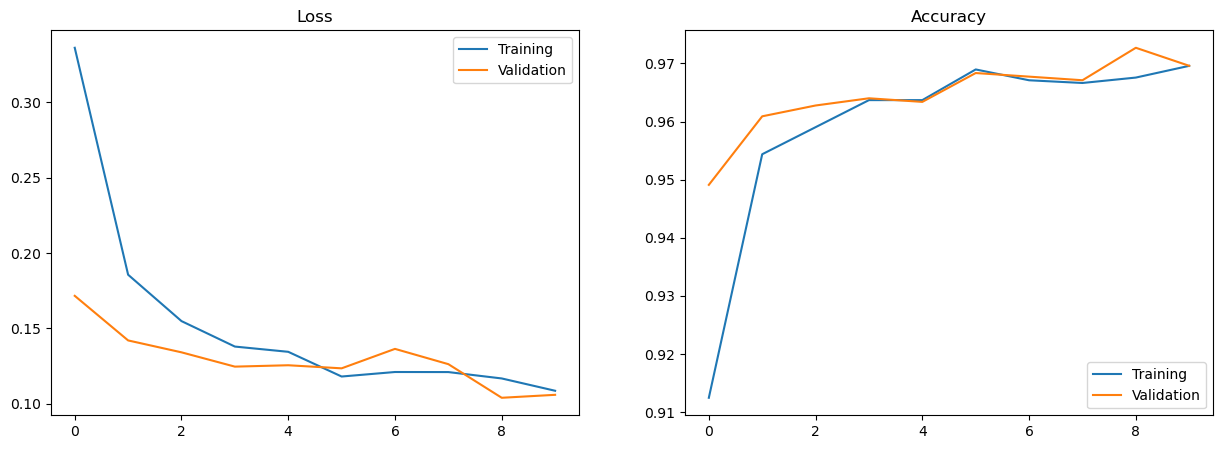

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history.history['loss'], label='Training')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history.history['accuracy'], label='Training')
ax[1].plot(history.history['val_accuracy'], label='Validation')
ax[1].legend(loc="lower right")

In [22]:
pickle.dump(model, open('Word2Vec_with_TensorflowLSTM.sav', 'wb'))

INFO:tensorflow:Assets written to: ram://832c363a-de11-4795-a552-f7ee2838ee04/assets


INFO:tensorflow:Assets written to: ram://832c363a-de11-4795-a552-f7ee2838ee04/assets


<h3> Max Len = 1000 </h3>

In [14]:
max_len = 1000

sequences = tokenizer.texts_to_sequences(X_train)
X_train_seq = kprocessing.sequence.pad_sequences(sequences, maxlen=max_len)

X_test_seq = kprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

In [15]:
max_words = len(reverse_voc)
emb_matrix = np.zeros((max_words + 1, 100))
for i in range(max_words):
    if reverse_voc[i+1] in embed:
        emb_matrix[i+1, :] = embed[reverse_voc[i+1]]

emb_size = emb_matrix.shape[1]

In [16]:
emb_matrix.shape

(425, 100)

In [22]:
input_ = layers.Input(shape = X_train_seq[0,:].shape,name='input')
# Embedding layer (voc size plus un ("UNK", word with index 0)), using the pre-trained emb_matrix obtained from Word2Vec
x = layers.Embedding(max_words+1,emb_size,weights=[emb_matrix],trainable=False, name='embedding')(input_)
x = layers.Bidirectional(layers.LSTM(15,dropout=0.2),name='bidirectional-lstm')(x) # LSTM layer
x = layers.Dropout(0.2, name='dropout')(x)
x = layers.Dense(64, activation='relu', name='dense')(x)
output = layers.Dense(nr_categories,activation='softmax', name='classification')(x)

model = models.Model(input_, output)

opt = optimizers.Adam(learning_rate=0.01, beta_1=0.9)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 1000)]            0         
                                                                 
 embedding (Embedding)       (None, 1000, 100)         42500     
                                                                 
 bidirectional-lstm (Bidirec  (None, 30)               13920     
 tional)                                                         
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense (Dense)               (None, 64)                1984      
                                                                 
 classification (Dense)      (None, 7)                 455       
                                                           

In [24]:
X_train_seq[0].shape

(1000,)

In [25]:
history = model.fit(X_train_seq, y_train, batch_size=64, shuffle=True, epochs=10, validation_data=(X_test_seq, y_test))

Epoch 1/10
101/101 [==============================] - 28s 255ms/step - loss: 0.2715 - accuracy: 0.9364 - val_loss: 0.1266 - val_accuracy: 0.9646
Epoch 2/10
101/101 [==============================] - 25s 246ms/step - loss: 0.1557 - accuracy: 0.9620 - val_loss: 0.1122 - val_accuracy: 0.9665
Epoch 3/10
101/101 [==============================] - 25s 246ms/step - loss: 0.1397 - accuracy: 0.9645 - val_loss: 0.1102 - val_accuracy: 0.9721
Epoch 4/10
101/101 [==============================] - 25s 245ms/step - loss: 0.1294 - accuracy: 0.9662 - val_loss: 0.1030 - val_accuracy: 0.9702
Epoch 5/10
101/101 [==============================] - 25s 245ms/step - loss: 0.1159 - accuracy: 0.9696 - val_loss: 0.1044 - val_accuracy: 0.9733
Epoch 6/10
101/101 [==============================] - 25s 247ms/step - loss: 0.1187 - accuracy: 0.9677 - val_loss: 0.1028 - val_accuracy: 0.9702
Epoch 7/10
101/101 [==============================] - 25s 248ms/step - loss: 0.1089 - accuracy: 0.9696 - val_loss: 0.1050 - val_ac

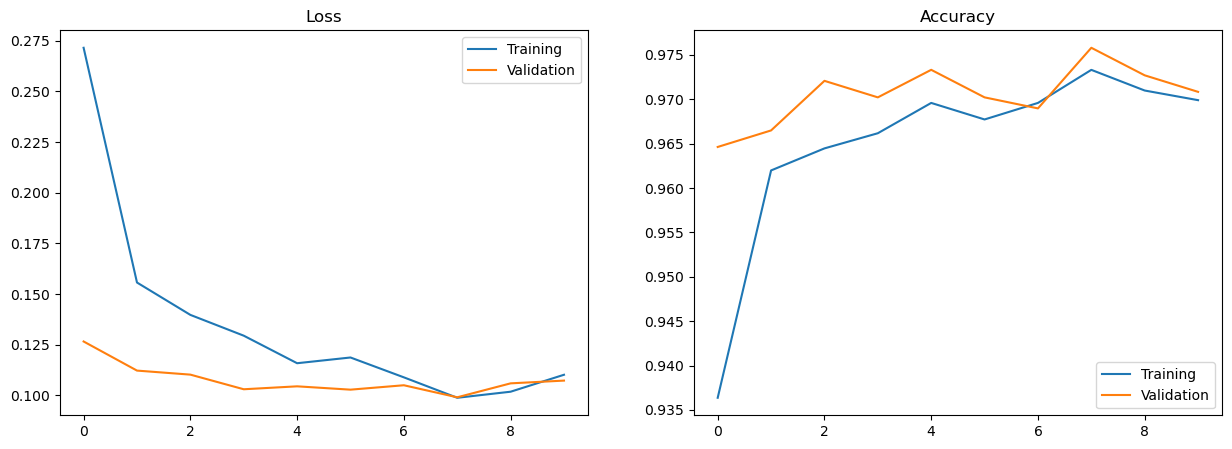

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history.history['loss'], label='Training')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history.history['accuracy'], label='Training')
ax[1].plot(history.history['val_accuracy'], label='Validation')
ax[1].legend(loc="lower right")

<h3>Max Len = 2500</h3>

In [27]:
max_len = 2500

sequences = tokenizer.texts_to_sequences(X_train)
X_train_seq = kprocessing.sequence.pad_sequences(sequences, maxlen=max_len)

X_test_seq = kprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

In [28]:
max_words = len(reverse_voc)
emb_matrix = np.zeros((max_words + 1, 100))
for i in range(max_words):
    if reverse_voc[i+1] in embed:
        emb_matrix[i+1, :] = embed[reverse_voc[i+1]]

emb_size = emb_matrix.shape[1]

In [29]:
emb_matrix.shape

(425, 100)

In [30]:
input_ = layers.Input(shape = X_train_seq[0,:].shape,name='input')
# Embedding layer (voc size plus un ("UNK", word with index 0)), using the pre-trained emb_matrix obtained from Word2Vec
x = layers.Embedding(max_words+1,emb_size,weights=[emb_matrix],trainable=False, name='embedding')(input_)
x = layers.Bidirectional(layers.LSTM(15,dropout=0.2),name='bidirectional-lstm')(x) # LSTM layer
x = layers.Dropout(0.2, name='dropout')(x)
x = layers.Dense(64, activation='relu', name='dense')(x)
output = layers.Dense(nr_categories,activation='softmax', name='classification')(x)

model = models.Model(input_, output)

opt = optimizers.Adam(learning_rate=0.01, beta_1=0.9)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2500)]            0         
                                                                 
 embedding (Embedding)       (None, 2500, 100)         42500     
                                                                 
 bidirectional-lstm (Bidirec  (None, 30)               13920     
 tional)                                                         
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense (Dense)               (None, 64)                1984      
                                                                 
 classification (Dense)      (None, 7)                 455       
                                                           

In [32]:
history = model.fit(X_train_seq, y_train, batch_size=64, shuffle=True, epochs=10, validation_data=(X_test_seq, y_test))

Epoch 1/10
101/101 [==============================] - 68s 656ms/step - loss: 0.3083 - accuracy: 0.9226 - val_loss: 0.1293 - val_accuracy: 0.9646
Epoch 2/10
101/101 [==============================] - 64s 637ms/step - loss: 0.1477 - accuracy: 0.9615 - val_loss: 0.1111 - val_accuracy: 0.9690
Epoch 3/10
101/101 [==============================] - 64s 637ms/step - loss: 0.1222 - accuracy: 0.9690 - val_loss: 0.1103 - val_accuracy: 0.9696
Epoch 4/10
101/101 [==============================] - 64s 638ms/step - loss: 0.1181 - accuracy: 0.9679 - val_loss: 0.0987 - val_accuracy: 0.9708
Epoch 5/10
101/101 [==============================] - 65s 639ms/step - loss: 0.1160 - accuracy: 0.9680 - val_loss: 0.1087 - val_accuracy: 0.9708
Epoch 6/10
101/101 [==============================] - 64s 635ms/step - loss: 0.1069 - accuracy: 0.9680 - val_loss: 0.1085 - val_accuracy: 0.9677
Epoch 7/10
101/101 [==============================] - 66s 651ms/step - loss: 0.1017 - accuracy: 0.9719 - val_loss: 0.1003 - val_ac

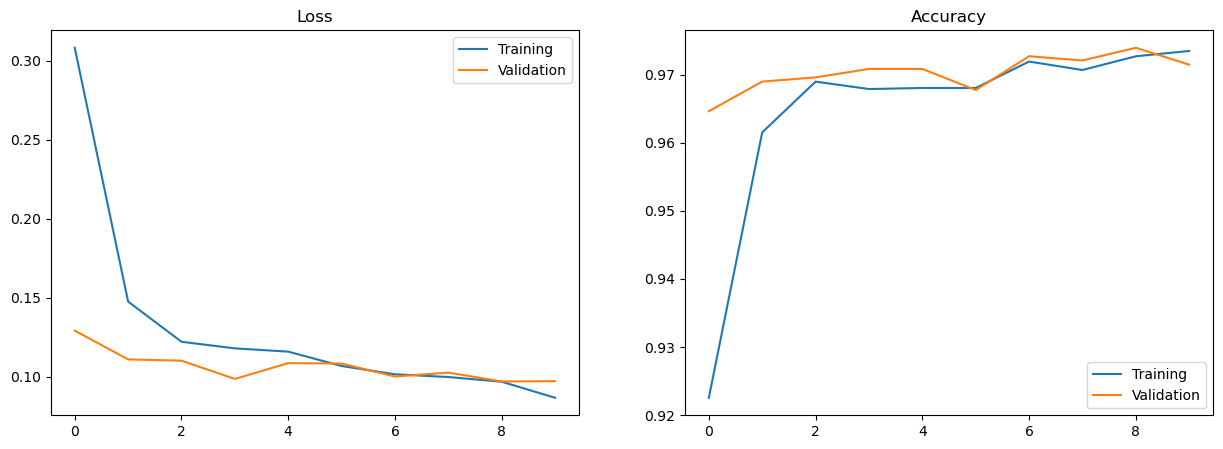

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history.history['loss'], label='Training')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history.history['accuracy'], label='Training')
ax[1].plot(history.history['val_accuracy'], label='Validation')
ax[1].legend(loc="lower right")